intercept total: 1.8490840448339725
slope total: [0.19655539]
дисперсия: 0.36069505053169026


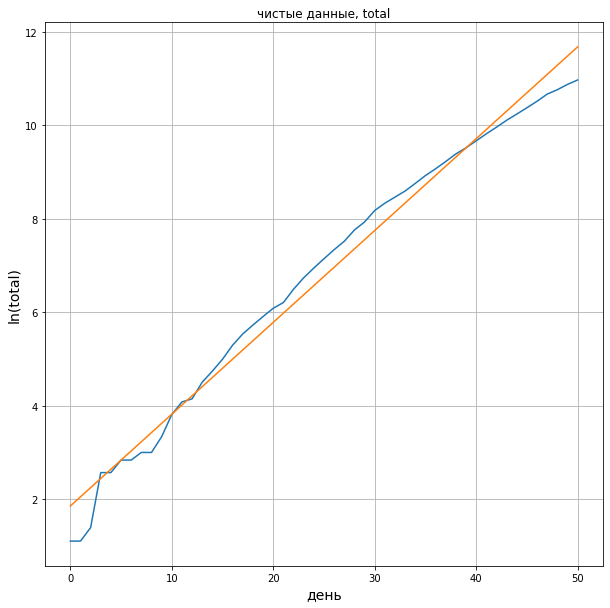

In [140]:
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import openpyxl
import numpy as np
import matplotlib.pyplot as plt
from math import exp, pi, cos, log
import scipy.stats as sps
import numpy as np
import ipywidgets as widgets


book=openpyxl.open("cow.xlsx",read_only=True)  #открываем файл
sheet = book.active

total_cases=[]

days = np.array([i for i in range(51)]).reshape((-1, 1)) #в качестве икса

for i in range(51):
    total_cases.append(float(sheet[34+i][1].value))    

LNtcases=[]

for i in range(len(total_cases)):   #логарифмируем
    LNtcases.append(log(total_cases[i]))

#обучаем простую линейную регрессию total
model = LinearRegression()
model.fit(days,LNtcases)
print('intercept total:', model.intercept_)
print('slope total:', model.coef_)

learned = model.predict(days)

#data=np.array([days,LNtcases]).T.tolist()


plt.figure(figsize=(10, 10))
plt.plot(days, LNtcases,days,learned)               
plt.title("чистые данные, total") 
plt.ylabel("ln(total)", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  

#ищем дисперсию данных
summ=0
for i in range(len(total_cases)):
    summ=summ+(LNtcases[i]-learned[i])**2
disper=(summ/len(total_cases))**(1/2)
print('дисперсия:', disper)




In [141]:
cur_mu, cur_sigma = np.array([0, 0]), 2*np.array([[1, 0], [0, 1]]) #параметры априорного распределения

one = [1] * 51
dayss=np.array([i for i in range(51)])

t=np.stack((one,dayss),axis=1) #матрица признаков

#пересчитываем параметры
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), np.transpose(y) ) )
    return mu_n, sigma_n

#новые параметры
cur_muU, cur_sigmaA = bayesian_update(cur_mu, cur_sigma, t,LNtcases,disper )
print(cur_sigmaA)
print(cur_muU)

[[ 9.86074635e-03 -2.92893012e-04]
 [-2.92893012e-04  1.17306639e-05]]
[1.83999616 0.19682503]


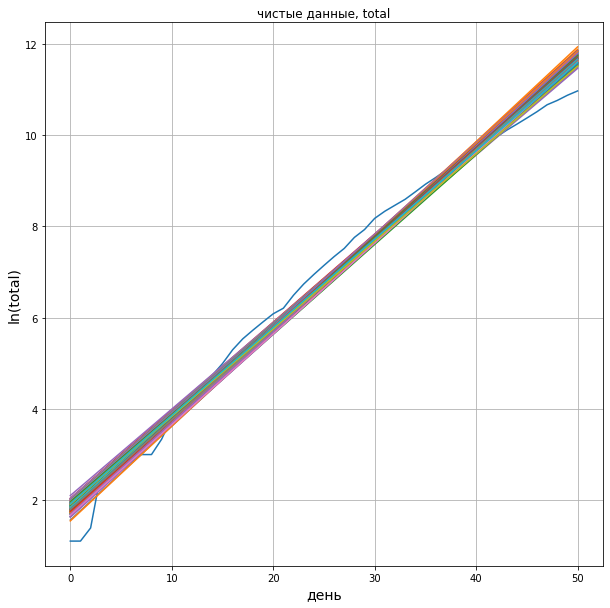

In [142]:
#сэмплируем экспоненты
sample = sps.multivariate_normal(
    mean=cur_muU, cov=cur_sigmaA
).rvs(size=100)


plt.figure(figsize=(10, 10))
plt.plot(days, LNtcases)
for i in range(99):
    plt.plot(days,days*sample[i][1]+sample[i][0])
plt.title("чистые данные, total") 
plt.ylabel("ln(total)", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  



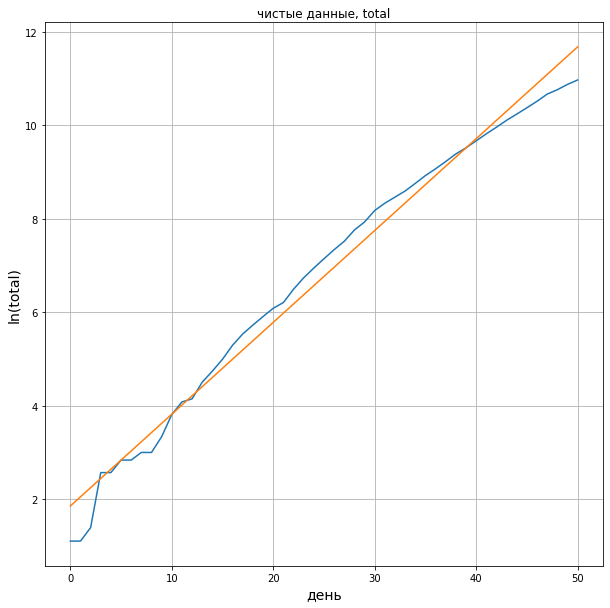

In [143]:
sampled=days*sample.mean(axis=0)[0]

plt.figure(figsize=(10, 10))
plt.plot(days, LNtcases,days,learned)               
plt.title("чистые данные, total") 
plt.ylabel("ln(total)", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  


intercept new: -0.4597598219715451
slope new: [ 0.          0.28652232 -0.00210877]
0.2865223160744789


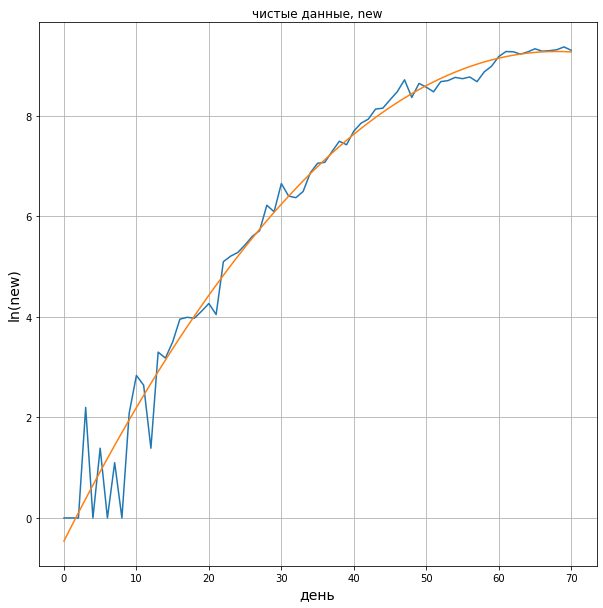

In [155]:
#обучаем новые случаи

from sklearn.preprocessing import PolynomialFeatures
quadratic = PolynomialFeatures(degree=2)


new_cases=[]
daysss=np.array([i for i in range(71)]).reshape((-1, 1))
X_quad = quadratic.fit_transform(daysss)

for i in range(71):
    new_cases.append(float(sheet[34+i][2].value))

LNncases=[]

for i in range(71):
    LNncases.append(log(new_cases[i]))

    
#обучаем линейную регрессию new с квадратичными признаками
model_n = LinearRegression()
model_n.fit(X_quad,LNncases)
print('intercept new:', model_n.intercept_)
print('slope new:', model_n.coef_)

learned_n = model_n.predict(quadratic.fit_transform(daysss))


plt.figure(figsize=(10, 10))
plt.plot(daysss, LNncases,daysss,learned_n)               
plt.title("чистые данные, new") 
plt.ylabel("ln(new)", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  

print(model_n.coef_[1])


In [156]:
summm=0
for i in range(len(total_cases)):
    summm=summm+(LNncases[i]-learned_n[i])**2
disperr=(summm/len(LNncases))**(1/2)
print('дисперсия:', disper)

one = [1] * 71
dayss=np.array([i for i in range(71)])
dayss_2=np.array([i**2 for i in range(71)])

tt=np.stack((one,dayss,dayss_2),axis=1) #матрица признаков


cur_mu, cur_sigma = np.array([0, 0,0]), np.array([[1, 0,0], [0, 1,0],[0, 0,1]]) #параметры априорного распределения

cur_muUU, cur_sigmaAA = bayesian_update(cur_mu, cur_sigma, tt,LNncases, disperr )

print(cur_muUU)

дисперсия: 0.36069505053169026
[-0.45015016  0.2859704  -0.0021022 ]


Выборочное среденее: [-0.44647533  0.28522654 -0.0020883 ]
Выборочная матрица ковариаций:
 [[ 2.40041300e-02 -1.36833355e-03  1.71073128e-05]
 [-1.36833355e-03  1.01847463e-04 -1.40316462e-06]
 [ 1.71073128e-05 -1.40316462e-06  2.02660354e-08]]


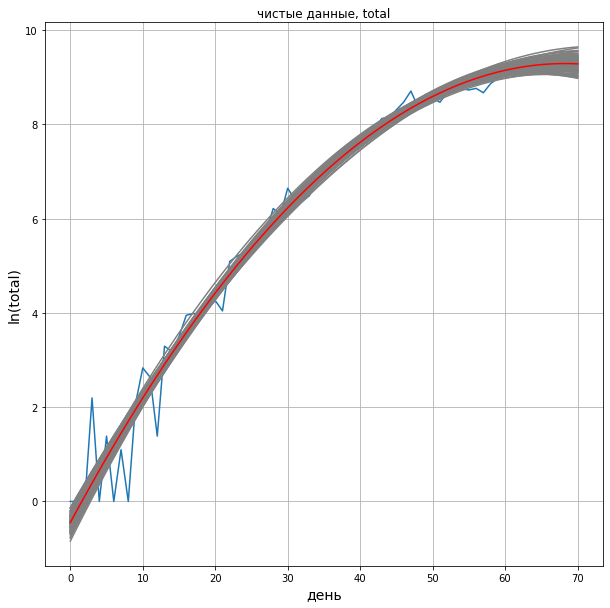

In [157]:
#сэмплируем кривые
samplee = sps.multivariate_normal(
    mean=cur_muUU, cov=cur_sigmaAA
).rvs(size=100)

print('Выборочное среденее:', samplee.mean(axis=0))
print('Выборочная матрица ковариаций:\n', np.cov(samplee.T))

plt.figure(figsize=(10, 10))
plt.plot(daysss, LNncases)
for i in range(99):
    plt.plot(daysss,(daysss**2)*samplee[i][2]+daysss*samplee[i][1]+samplee[i][0],color="0.5")
plt.plot(daysss,(daysss**2)*samplee.mean(axis=0)[2]+daysss*samplee.mean(axis=0)[1]+samplee.mean(axis=0)[0],color="r")
plt.title("чистые данные, new cases") 
plt.ylabel("ln(new cases)", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  

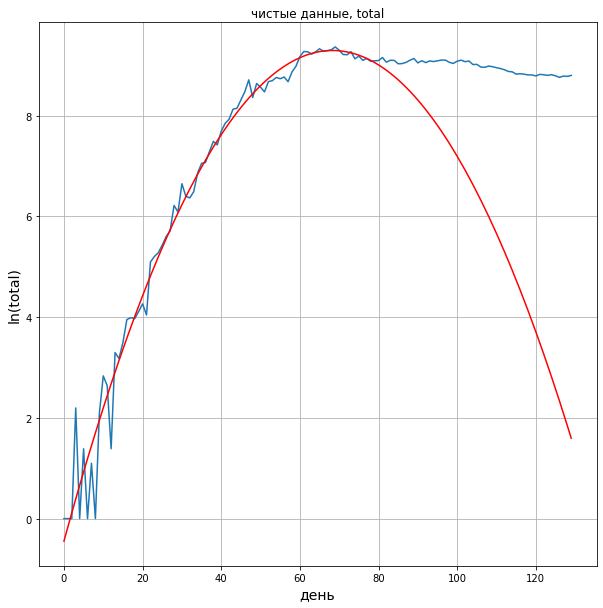

In [160]:
new_cases=[]
daysss=np.array([i for i in range(130)]).reshape((-1, 1))
X_quad = quadratic.fit_transform(daysss)

for i in range(130):
    new_cases.append(float(sheet[34+i][2].value))

LNncases=[]

for i in range(130):
    LNncases.append(log(new_cases[i]))

plt.figure(figsize=(10, 10))
plt.plot(daysss, LNncases)
#for i in range(99):
    #plt.plot(daysss,(daysss**2)*samplee[i][2]+daysss*samplee[i][1]+samplee[i][0],color="0.5")
plt.plot(daysss,(daysss**2)*samplee.mean(axis=0)[2]+daysss*samplee.mean(axis=0)[1]+samplee.mean(axis=0)[0],color="r")
plt.title("чистые данные, new cases") 
plt.ylabel("ln(new cases)", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  

## Красная линия - усредненное из семплированных пресказание

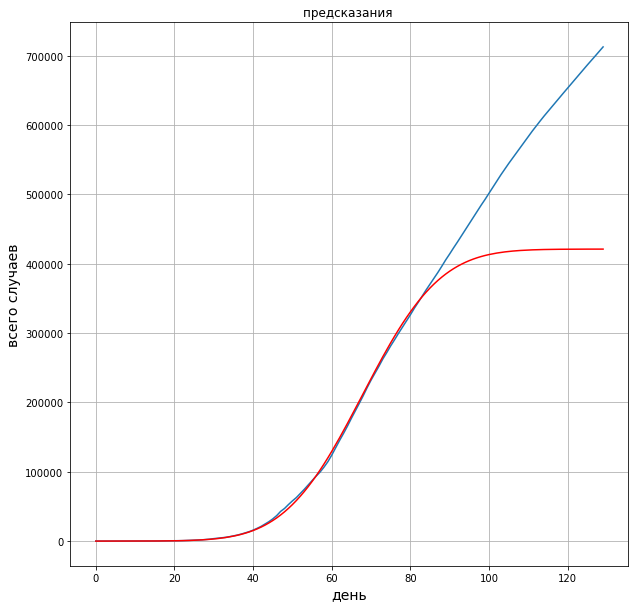

In [178]:
newww=(daysss**2)*samplee.mean(axis=0)[2]+daysss*samplee.mean(axis=0)[1]+samplee.mean(axis=0)[0]
enewww=[]
for i in range(len(newww)):
    enewww.append(exp(newww[i]))

total_casess=[]

for i in range(130):
    total_casess.append(float(sheet[34+i][1].value))
    

total=[]
for i in range(len(LNncases)+1):
    if i>0:
        summa=0
        for j in range(i):
            summa=summa+enewww[j]
        total.append(summa)
    
plt.figure(figsize=(10, 10))
plt.plot(daysss,total_casess )

plt.plot(daysss,total,color="r")
plt.title("предсказания ") 
plt.ylabel("всего случаев", fontsize=14) 
plt.xlabel("день", fontsize=14)
plt.grid(True)  